In [68]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from scipy import stats
from functools import reduce

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Some matplotlib options
%matplotlib inline
matplotlib.style.use("ggplot")

# General pandas options
pd.set_option('display.max_colwidth', -1)  # Show the entire column 
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 10000 

# Seaborn options
sns.set_style("whitegrid")


# model to implement
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [69]:
df = pd.read_csv("D:/Praxis/Datasets/Kaggle/WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(df.shape)

(1470, 35)


In [70]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [72]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

# Looking at each column and generating hypothesis w.r.t to  Attrition
1) Age = High Age, High Experience 
2) High Daily Rate , Less Attrition 
3) Less distance, less attrition
4) High Education , High Income
5) High Environment Satisfaction, Less attrition
6) High Job Satisfaction, Less attrition
7) High NumCompaniesWorked, High salary, High chance of leaving for more saary
8) High Overtime High Attrition,who are working overtime and who in many cases have a relatively low salary 
9) High percent salary hike less attrition
10) High performance rating less attrition 
11) stock option yes, less attrition
12) work life balance high, less attrition
13) high years at company, less attrition
14) high years since last promotion ,  high attrition

# encoding categorical variables into numerical

In [73]:
df.Attrition = df.Attrition.astype("category")
df.Attrition = df.Attrition.cat.reorder_categories(['No','Yes'])
df.Attrition = df.Attrition.cat.codes

In [74]:
df.Attrition.dtype

dtype('int8')

In [75]:
df.BusinessTravel.value_counts() # I am considering them in order.

Travel_Rarely        1043
Travel_Frequently    277 
Non-Travel           150 
Name: BusinessTravel, dtype: int64

In [76]:
df.BusinessTravel = df.BusinessTravel.astype("category")
df.BusinessTravel = df.BusinessTravel.cat.reorder_categories(['Non-Travel','Travel_Rarely','Travel_Frequently'])
df.BusinessTravel = df.BusinessTravel.cat.codes

In [77]:
df.Department.value_counts() # This is nominal data here label encoding and just assigning nos. won't work so I create dummy variables.

Research & Development    961
Sales                     446
Human Resources           63 
Name: Department, dtype: int64

In [78]:
df.EducationField.value_counts()  # This is nominal data here label encoding and just assigning nos. won't work so I create dummy variables.

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other               82 
Human Resources     27 
Name: EducationField, dtype: int64

In [79]:
df.Gender.value_counts()  # This is nominal data here label encoding and just assigning nos. won't work so I create dummy variables.

Male      882
Female    588
Name: Gender, dtype: int64

In [80]:
df.JobRole.value_counts() # This is nominal data here label encoding and just assigning nos. won't work so I create dummy variables.

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative         83 
Research Director            80 
Human Resources              52 
Name: JobRole, dtype: int64

In [81]:
df.MaritalStatus.value_counts() # This is nominal data here label encoding and just assigning nos. won't work so I create dummy variables.

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

In [82]:
df.Over18.value_counts() # constant so delete

Y    1470
Name: Over18, dtype: int64

In [83]:
df.OverTime.value_counts()

No     1054
Yes    416 
Name: OverTime, dtype: int64

In [84]:
df.OverTime = df.OverTime.astype("category")
df.OverTime = df.OverTime.cat.reorder_categories(['No','Yes'])
df.OverTime = df.OverTime.cat.codes

# EDA Univariate analysis # to check distribution 

# Distribution plot for numerical variables
# Frequency count plot for categorical variables

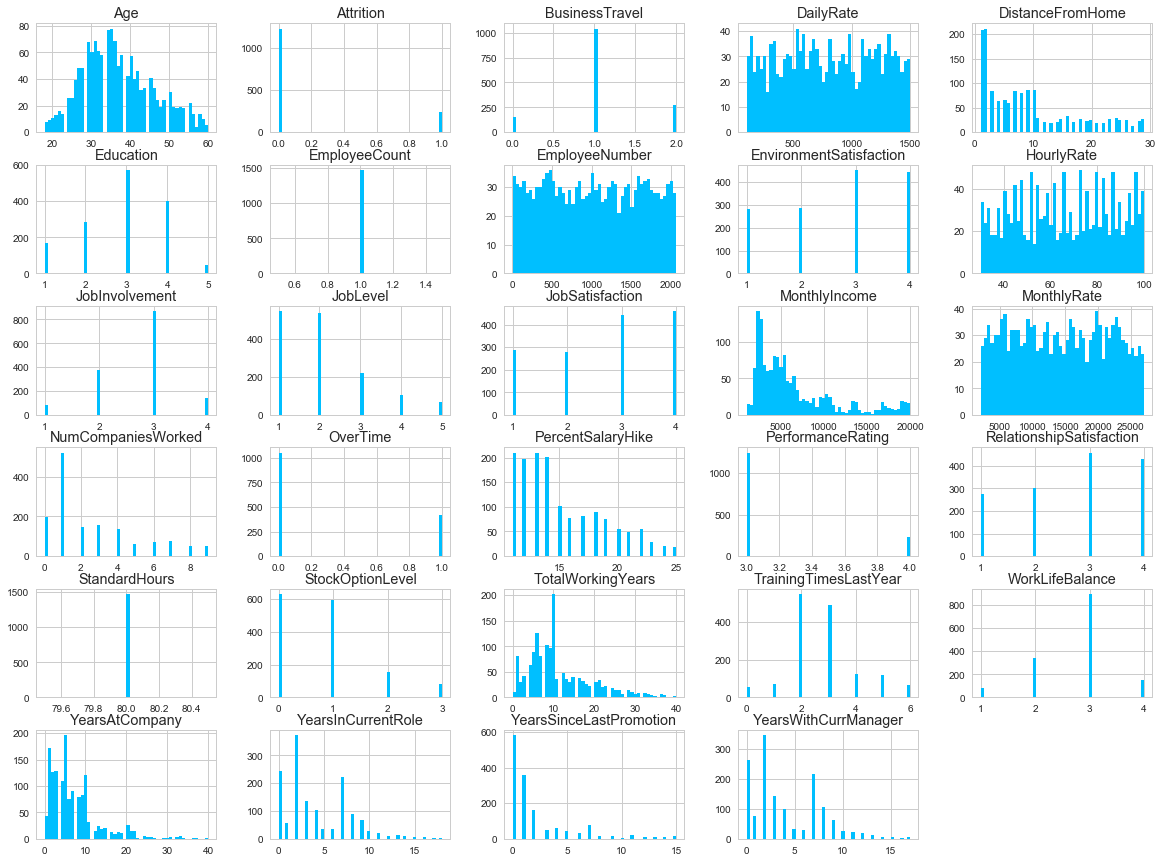

In [85]:
# Plot for all variables distribution + Count
# Graph distribution
df.hist (bins=50, figsize=(20,15), color = 'deepskyblue')
plt.show()

In [86]:
#seprating numerical columns from dataframe
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','int8']

newdf = df.select_dtypes(include=numerics)

# Distribution plot for numerical variables
# Frequency count plot for categorical variables

In [87]:
newdf.columns # numerical variable

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'DistanceFromHome',
       'Education', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

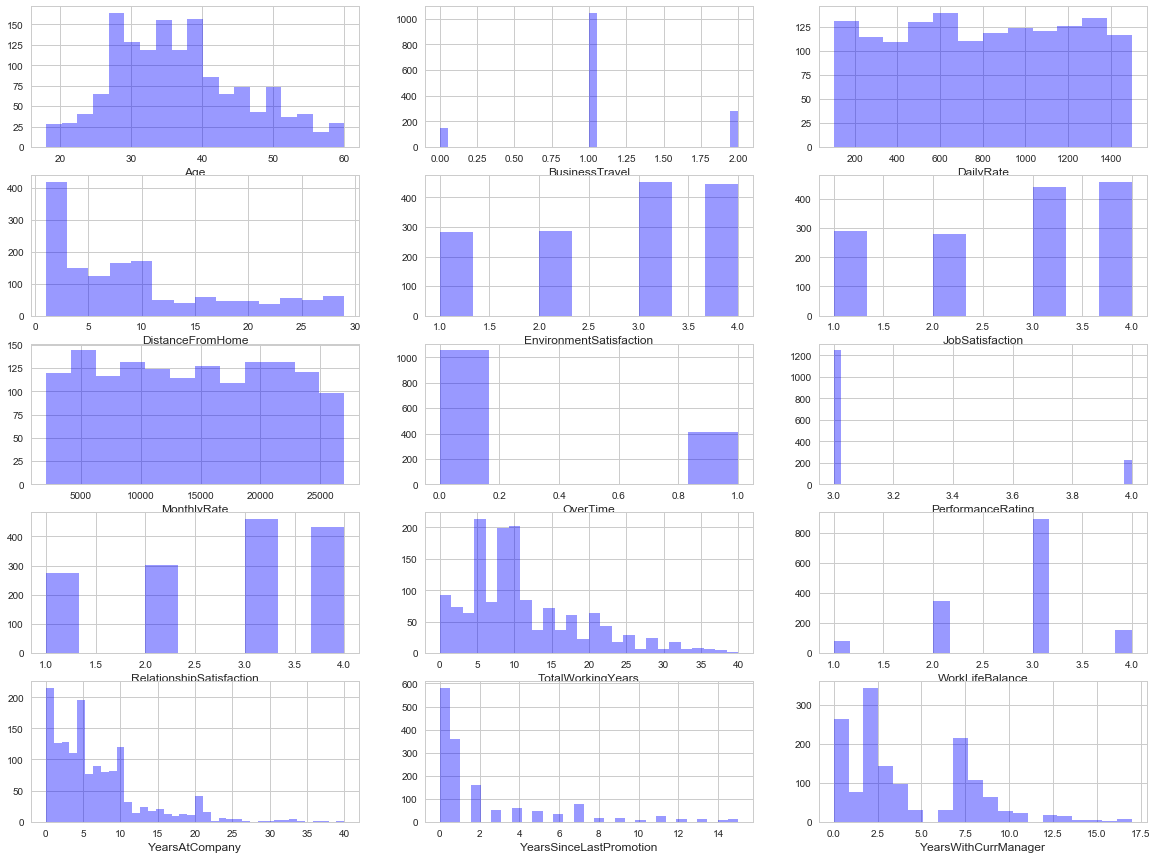

In [88]:
# Create a figure space matrix consisting of 3 columns and 2 rows
fig, ax = plt.subplots(figsize=(20,15), ncols=3, nrows=5)
# The amount of space above titles
"""y_title_margin = .2
ax[0][0].set_title("Age",y = y_title_margin)
ax[0][1].set_title("BusinessTravel",y = y_title_margin)
ax[0][2].set_title("DailyRate",y = y_title_margin)
ax[1][0].set_title("DistanceFromHome",y = y_title_margin)
ax[1][1].set_title("EnvironmentSatisfaction",y = y_title_margin)
ax[1][2].set_title("JobSatisfaction",y = y_title_margin)
ax[2][0].set_title("MonthlyRate",y = y_title_margin)
ax[2][1].set_title("OverTime",y = y_title_margin)
ax[2][2].set_title("PerformanceRating",y = y_title_margin)
ax[3][0].set_title("RelationshipSatisfaction",y = y_title_margin)
ax[3][1].set_title("TotalWorkingYears",y = y_title_margin)
ax[3][2].set_title("WorkLifeBalance",y = y_title_margin)
ax[4][0].set_title("YearsAtCompany",y = y_title_margin)
ax[4][1].set_title("YearsSinceLastPromotion",y = y_title_margin)
ax[4][2].set_title("YearsWithCurrManage",y = y_title_margin)"""

sns.distplot(df.Age,kde=False,color="b", ax=ax[0][0])
sns.distplot(df.BusinessTravel,kde=False,color="b", ax=ax[0][1])
sns.distplot(df.DailyRate,kde=False,color="b", ax=ax[0][2])
sns.distplot(df.DistanceFromHome,kde=False,color="b", ax=ax[1][0])
sns.distplot(df.EnvironmentSatisfaction,kde=False,color="b", ax=ax[1][1])
sns.distplot(df.JobSatisfaction,kde=False,color="b", ax=ax[1][2])
sns.distplot(df.MonthlyRate,kde=False,color="b", ax=ax[2][0])
sns.distplot(df.OverTime,kde=False,color="b", ax=ax[2][1])
sns.distplot(df.PerformanceRating,kde=False,color="b", ax=ax[2][2])
sns.distplot(df.RelationshipSatisfaction,kde=False,color="b", ax=ax[3][0])
sns.distplot(df.TotalWorkingYears,kde=False,color="b", ax=ax[3][1])
sns.distplot(df.WorkLifeBalance,kde=False,color="b", ax=ax[3][2])
sns.distplot(df.YearsAtCompany,kde=False,color="b", ax=ax[4][0])
sns.distplot(df.YearsSinceLastPromotion,kde=False,color="b", ax=ax[4][1])
sns.distplot(df.YearsWithCurrManager,kde=False,color="b", ax=ax[4][2])



# insights from univariate analysis of numerical data
1) Age = max employ has age in range of 27-29, 35-37, 39-40
2) Business_travel = Travel_Rarely 1043, Travel_Frequently 277 ,Non-Travel  150
3) Daily rate = mostly between range of 115- 130 for all employees
4) Distance from home = Good no. of  people live near office range of distance = 0-3
5) Environment satidfaction = most people are satisfied with environment of company as they have rated it 3 and 4 and same for job satisfaction and same for relationship satisfaction this means that less employee are not satisfied and thus less people have higher chance of attrition.
6) overtime = less people do overtime and thus they might have higher chance of attrition
7) worklife balance =  most people have balanced life b/w work and personal life but some have rated it 1 and 2 thus they have high chance of attrition.
8) YearsSinceLastPromotion = most people got promoted recentely as there are more people who in range of 0-1 years and hypothesis is this that poeple who did not get fromotion from 2-5 years are likely to churn more.

In [89]:
#separting categorical columns 

In [90]:
cat = ['object']

newdf1 = df.select_dtypes(include=cat)
newdf1.columns

Index(['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus',
       'Over18'],
      dtype='object')

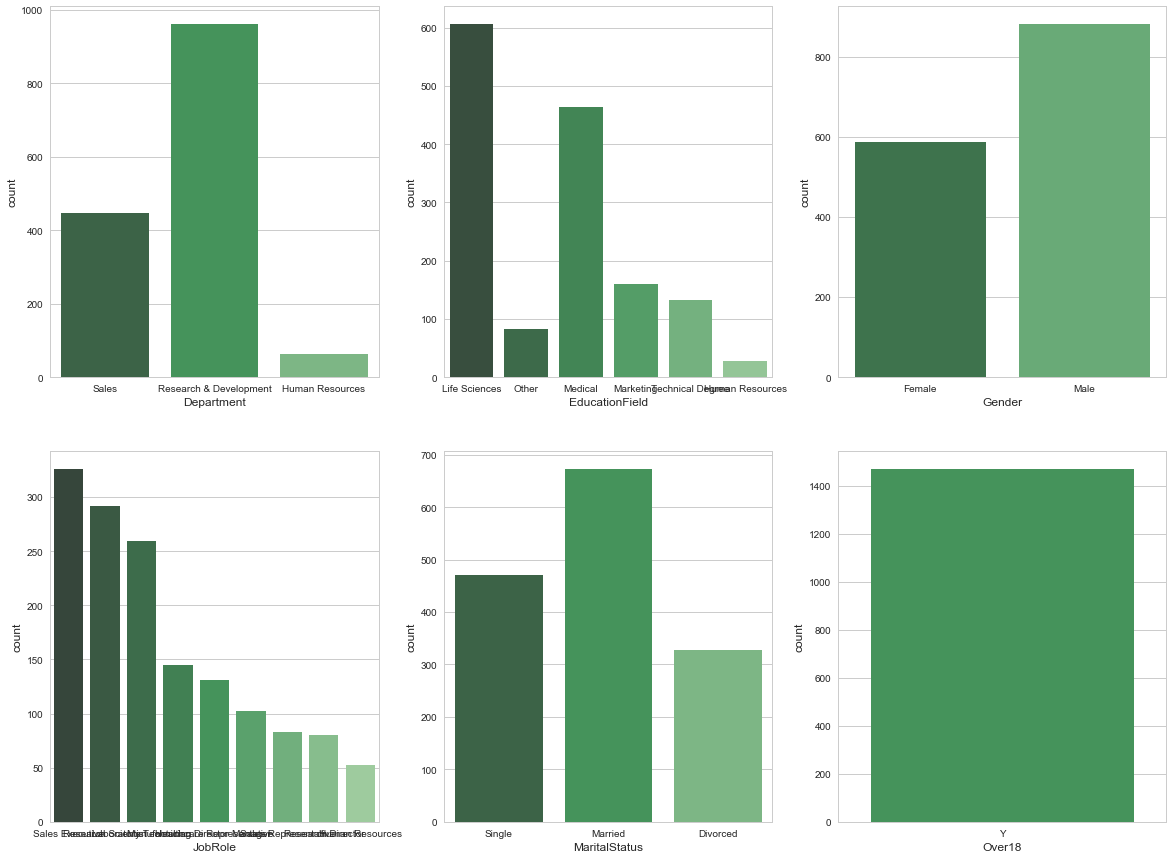

In [91]:
# Create a figure space matrix consisting of 3 columns and 2 rows
fig, ax = plt.subplots(figsize=(20,15), ncols=3, nrows=2)
sns.countplot(x="Department",data=df,palette="Greens_d",ax= ax[0][0])
sns.countplot(x="EducationField",data=df,palette="Greens_d",ax= ax[0][1])
sns.countplot(x="Gender",data=df,palette="Greens_d",ax= ax[0][2])
sns.countplot(x="JobRole",data=df,palette="Greens_d",ax= ax[1][0])
sns.countplot(x="MaritalStatus",data=df,palette="Greens_d",ax= ax[1][1])
sns.countplot(x="Over18",data=df,palette="Greens_d",ax= ax[1][2]) # drop Over18

# Bivariate analysis with respect to target variable

In [92]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

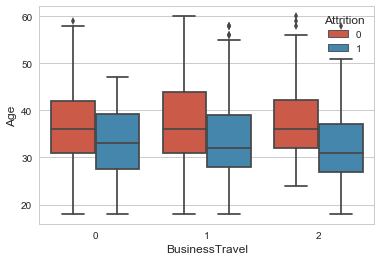

In [93]:
# Create a figure space matrix consisting of 3 columns and 2 rows ## box plot for categorical vs numerical
sns.boxplot(x="BusinessTravel",y="Age",hue="Attrition",data=df) 
# we can conclude that most employers who are in range of 27-38 leave company.this can be due to career switch or want salary hike.

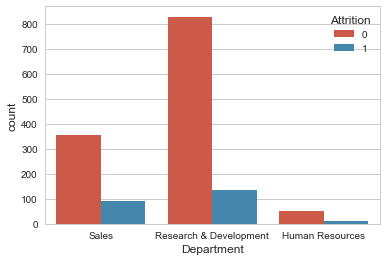

In [94]:
sns.countplot(x="Department",data=df,hue='Attrition')  # no specific relation

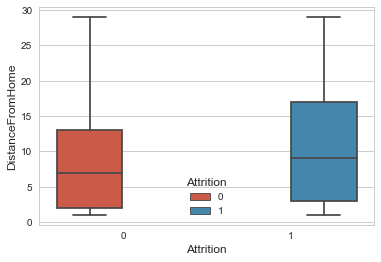

In [95]:
sns.boxplot(x="Attrition",y='DistanceFromHome',hue="Attrition",data=df) # no specific relation

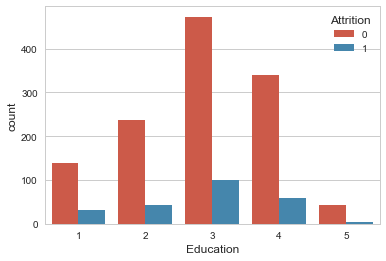

In [96]:
sns.countplot(x="Education",data=df,hue='Attrition') # no specific relation

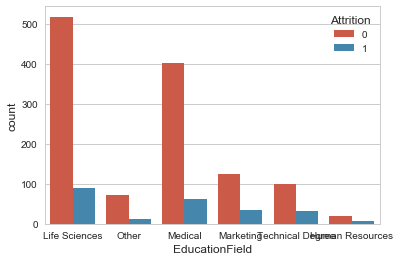

In [97]:
sns.countplot(x="EducationField",data=df,hue='Attrition') # no specific relation

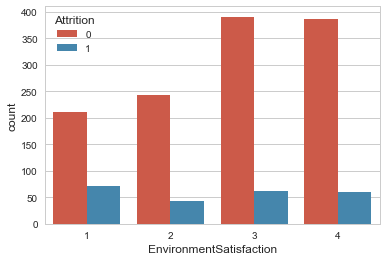

In [98]:
sns.countplot(x="EnvironmentSatisfaction",data=df,hue='Attrition') # we can see that % of attrition for environment satisfaction = 1,2 will be more that of 3 and 4.

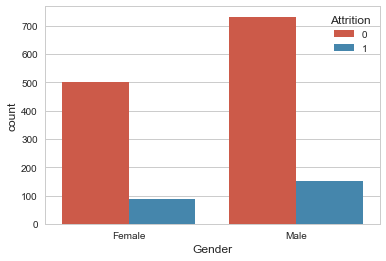

In [99]:
sns.countplot(x="Gender",data=df,hue='Attrition') #no specific relation

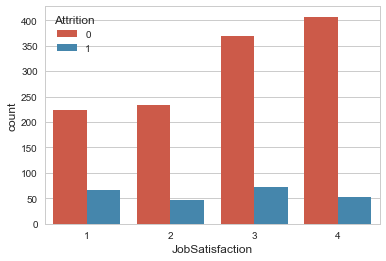

In [100]:
sns.countplot(x="JobSatisfaction",data=df,hue='Attrition') # we can see that % of attrition for job satisfaction = 1,2 will be more that of 3 and 4.

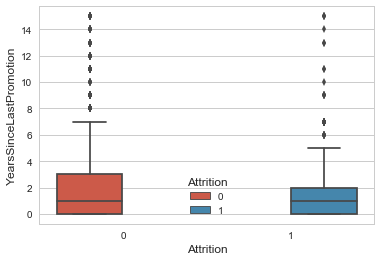

In [101]:
sns.boxplot(x="Attrition",y="YearsSinceLastPromotion",hue="Attrition",data=df)

In [102]:
True_Class = print(sum(df['Attrition']==1))
Total_length = print(len(df['Attrition']))
print((237/1470)*100) # percentage of class 1, checking class imbalance # it is not highly imbalanced but still we will use SMOTE for 1 model and do it without SMOTE for other model

237
1470
16.122448979591837


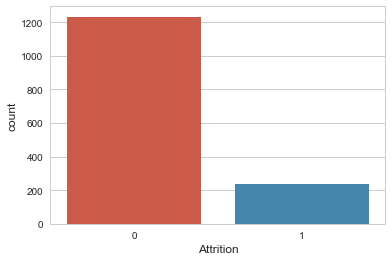

In [103]:
#Checking class imbalance
sns.countplot(x ='Attrition',data = df)

In [104]:
pandas_profiling.ProfileReport(df)

Number of variables,35
Number of observations,1470
Total Missing (%),0.0%
Total size in memory,371.9 KiB
Average record size in memory,259.1 B
Numeric,23
Categorical,5
Boolean,3
Date,0
Text (Unique),0
Rejected,4


# Encoding nominal data and removing constant and highly correlated data
Generally when making a predictive model, it would be preferable to train a model with features that are not too correlated with one another so that we do not need to deal with redundant features. In the case that we have quite a lot of correlated features one could perhaps apply a technique such as Principal Component Analysis (PCA) to reduce the feature space.

In [105]:
df = df.drop(['EmployeeCount','MonthlyIncome','Over18','StandardHours'],axis =1)
df = pd.get_dummies(df)

In [106]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1,1102,1,2,1,2,94,3,2,4,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,0,2,279,8,1,2,3,61,2,2,2,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1,1,1373,2,2,4,4,92,2,1,3,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,33,0,2,1392,3,4,5,4,56,3,1,3,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,0,1,591,2,1,7,1,40,3,1,2,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


# ML Models
Splitting Data into Train and Test sets
But before we even start training a model, we will have to partition our dataset into a training set and a test set (unlike Kaggle competitions where the train and test data are already segregated for you). To split our data we will utilise sklearn's

# Decision Tree

In [107]:
# Choose the dependent variable column (churn) and set it as target
target = df.Attrition
# Drop column churn and set everything else as features
features = df.drop("Attrition",axis=1)
# Import the train_test_split method
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

# Split data into train and test sets as well as for validation and testing
# Use that function to create the splits both for target and for features
# Set the test sample to be 25% of your observations
target_train, target_test, features_train, features_test = train_test_split(target,features,test_size=0.25,random_state=42)

In [108]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [109]:
# Import the classification algorithm
from sklearn.tree import DecisionTreeClassifier

# Initialize it and call model by specifying the random_state parameter
model = DecisionTreeClassifier(random_state=42,class_weight='balanced')

# Apply a decision tree model to fit features to the target
model.fit(features_train,target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [110]:
# Do k-fold cross-validation
cv_results = cross_val_score(model, # Pipeline
                             features_train, # Feature matrix
                             target_train, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores

In [111]:
# Calculate mean # cross validated score
CV_mean = cv_results.mean()
print(CV_mean*(100))

78.22686322686323


In [112]:
# overfited model
# Check the accuracy score of the prediction for the training set
print(model.score(features_train,target_train)*100)

# Check the accuracy score of the prediction for the test set
print(model.score(features_test,target_test)*100)

100.0
77.71739130434783


# Parameter tuning

In [113]:
# generate max depth range
depth = [i for i in range (5,21,1)]
samples = [i for i in range(50,450,1)]
Parameters = dict(max_depth = depth, min_samples_leaf = samples)

In [114]:
from sklearn.model_selection import GridSearchCV

In [115]:
Param_search = GridSearchCV(model,Parameters)

In [116]:
Param_search.fit(features_train,target_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_leaf': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [117]:
print(Param_search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 368}


# Tuned DT Model

In [118]:
model1 = DecisionTreeClassifier(random_state=42,class_weight='balanced',max_depth = 5, min_samples_leaf = 368)

In [119]:
model1.fit(features_train,target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=368, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [120]:
# Do k-fold cross-validation
cv_results1 = cross_val_score(model1, # Pipeline
                             features_train, # Feature matrix
                             target_train, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores
# Calculate mean # cross validated score
CV_mean1 = cv_results1.mean()
print(CV_mean1*(100))

63.061425061425055


In [121]:
# No overfiting
# Check the accuracy score of the prediction for the training set
print(model1.score(features_train,target_train)*100)

# Check the accuracy score of the prediction for the test set
print(model1.score(features_test,target_test)*100)

65.60798548094374
68.75


In [122]:
from sklearn.metrics import confusion_matrix,classification_report
print (confusion_matrix(target_test, model1.predict(features_test)))
print (classification_report(target_test, model1.predict(features_test)))

[[231  89]
 [ 26  22]]
             precision    recall  f1-score   support

          0       0.90      0.72      0.80       320
          1       0.20      0.46      0.28        48

avg / total       0.81      0.69      0.73       368



# Important features for DT model

In [123]:
important_features = model.feature_importances_
feature_list = list(features)
relative_importances = pd.DataFrame(index = feature_list, data = important_features, columns = ['Important'])

In [124]:
relative_importances.sort_values(by='Important', ascending = False)

,Important
OverTime,0.113808
Age,0.086606
TotalWorkingYears,0.079296
JobLevel,0.055610
DistanceFromHome,0.055499
PercentSalaryHike,0.053143
HourlyRate,0.051257
JobRole_Sales Executive,0.042717
YearsAtCompany,0.042348
StockOptionLevel,0.041468


In [125]:
selected_features = relative_importances[relative_importances.Important> 0.02]

In [126]:
selected_list = selected_features.index

In [127]:
feature_train_selected = features_train[selected_list]
feature_test_selected = features_test[selected_list]

# Random forest

In [128]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

seed = 0   # We set our random seed to zero for reproducibility

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 800,
    'warm_start': True, 
    'max_features': 0.3,
    'max_depth': 9,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

# Instantiate rf
rf = RandomForestClassifier(**rf_params)
            
# Fit rf to the training set    
rf.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=True)

In [129]:
# Do k-fold cross-validation
cv_results2 = cross_val_score(rf, # Pipeline
                             features_train, # Feature matrix
                             target_train, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores
# Calculate mean # cross validated score
CV_mean2 = cv_results2.mean()
print(CV_mean2*(100))

85.21048321048322


In [130]:
# Slight overfiting
# Check the accuracy score of the prediction for the training set
print(rf.score(features_train,target_train)*100)

# Check the accuracy score of the prediction for the test set
print(rf.score(features_test,target_test)*100)

93.64791288566244
87.5


In [133]:
from sklearn.metrics import confusion_matrix,classification_report
print (confusion_matrix(target_test, rf.predict(features_test)))
print (classification_report(target_test, rf.predict(features_test)))

[[318   2]
 [ 44   4]]
             precision    recall  f1-score   support

          0       0.88      0.99      0.93       320
          1       0.67      0.08      0.15        48

avg / total       0.85      0.88      0.83       368



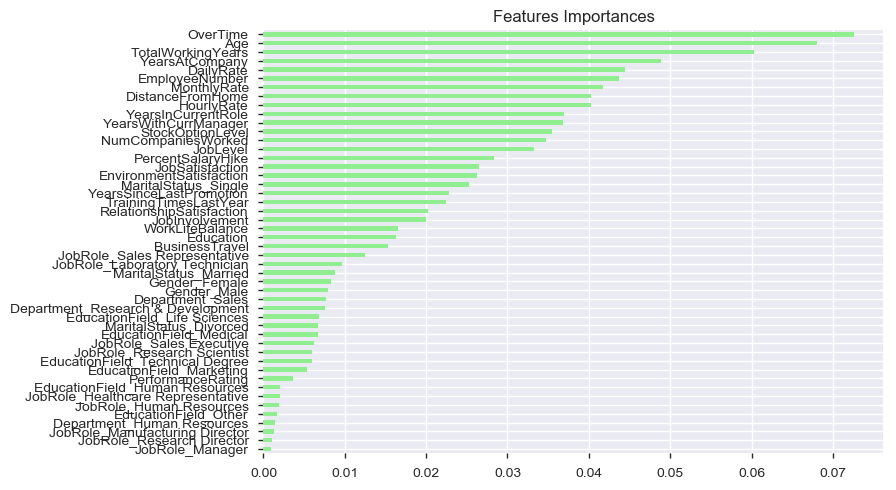

In [134]:
import matplotlib.pyplot as plt
#Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= features_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

"""Apparently, Overtime, Total Working Years, Age are the most important features according to rf. The importances of these two features add up to 14% roughly"""

# Most RF important features : Overtime, Marital Status

As observed in the plot of feature importances, it seems that our Random Forest Classifier has decided to rank the features of OverTime highest, which is followed by marital status.

I don't know about you, but working overtime to me does indeed affect my satisfaction derived from any job (and I have worked many an overtime). Maybe then it should come as no surprise that our classifier has caught on to this and thus ranked overtime the highest


# Logistic Regression

In [135]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(features_train,target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [139]:
# Do k-fold cross-validation
cv_results2 = cross_val_score(lr, # Pipeline
                             features_train, # Feature matrix
                             target_train, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores
# Calculate mean # cross validated score
CV_mean2 = cv_results2.mean()
print(CV_mean2*(100))

87.66093366093365


In [141]:
# No overfiting
# Check the accuracy score of the prediction for the training set
print(lr.score(features_train,target_train)*100)

# Check the accuracy score of the prediction for the test set
print(lr.score(features_test,target_test)*100)

89.29219600725953
89.67391304347827


In [143]:
from sklearn.metrics import confusion_matrix,classification_report
print (confusion_matrix(target_test, lr.predict(features_test)))
print (classification_report(target_test, lr.predict(features_test)))

[[310  10]
 [ 28  20]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.94       320
          1       0.67      0.42      0.51        48

avg / total       0.88      0.90      0.89       368



In [144]:
print(lr.coef_)
print(lr.intercept_)

[[-1.45772260e-02  8.05083592e-01 -2.02026161e-04  3.66071532e-02
   8.38692991e-02  2.43445622e-05 -3.24102480e-01  3.15161168e-03
  -3.90768708e-01 -3.02354269e-01 -3.12084090e-01  1.27081591e-05
   1.83150525e-01  1.75583102e+00 -1.32317028e-02  3.11441060e-01
  -1.47973567e-01 -2.72442823e-01 -6.56610799e-02 -1.04424497e-01
  -1.63473782e-01  1.03087654e-01 -1.23088508e-01  1.22537976e-01
  -1.30077268e-01  8.67259020e-02 -2.26959655e-01  3.25207037e-01
   1.55135643e-01 -2.37710515e-01  1.67893250e-01 -2.29381598e-01
  -7.99852826e-02  4.09021786e-01 -1.38314734e-01  3.23288018e-01
  -3.61242465e-01  1.16509761e-01  6.34532150e-01 -2.81107443e-02
  -1.24486836e-01 -1.88353524e-01 -1.90185395e-01 -6.75248181e-02
   3.93835156e-01 -3.23006854e-01 -1.34253575e-01  6.42233712e-01]]
[0.18497328]


In [146]:
probability = lr.predict_proba(features_test)

In [147]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target_test,probability[:,1])

0.8111328125

In [148]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

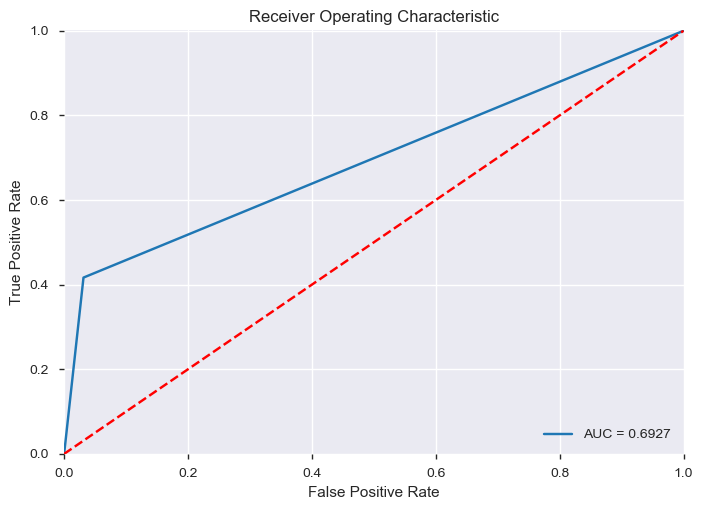

In [150]:
fpr, tpr, thresholds = roc_curve(target_test, lr.predict(features_test))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();